Goal: prediction models that predict taxi trip demand using support vector machines in spatio-temporal resolution (i.e., spatial-unit and time buckets). Your method should predict for each spatial unit (hexagon and census tract) and time-basket (e.g., 08am-11.59am) the taxi demand. Also adevise a reasonable validation strategy for your prediction model (i.e., definition of test, training data etc).

Approach for SVM:
- Simply start without a kernel. Then, gradually make your model complex by integrating different
kind of kernels. Also, use grid search to find optimal values for your hyperparameters.
- How good is your model? Evaluate your model’s performance and comment on its shortfalls.
- Show how you model’s performance varies as you increase or decrease temporal resolution for the
following period length: 1h, 2h, 6h, 24h. Also, vary the length of the hexagon edges. How does your
performance change when you only use census tract as spatial units?
- How could the model be improved further? Explain some of the improvement levers that you might
focus on in a follow-up project.


## Test on Synthetic Data

In [1]:
import numpy as np
from sklearn.svm import SVR

# Example dataset
time_bucket = np.array([1, 2, 3, 4, 5])  # Input variable 1: Time bucket
spatial_unit = np.array([10, 20, 30, 40, 50])  # Input variable 2: Spatial unit
taxi_demand = np.array([100, 200, 150, 250, 180])  # Target variable: Taxi demand

# Reshape the input variables
time_bucket = time_bucket.reshape(-1, 1)
spatial_unit = spatial_unit.reshape(-1, 1)

# Concatenate the input variables
X = np.concatenate((time_bucket, spatial_unit), axis=1)

# Create and train the SVR model without a kernel
svr = SVR(kernel='linear')
svr.fit(X, taxi_demand)

# Predicting on new data
new_time_bucket = np.array([6, 7, 8])  # New time bucket values
new_spatial_unit = np.array([60, 70, 80])  # New spatial unit values
new_X = np.concatenate((new_time_bucket.reshape(-1, 1), new_spatial_unit.reshape(-1, 1)), axis=1)
predictions = svr.predict(new_X)

print("Predicted taxi demand:", predictions)


Predicted taxi demand: [195.1 210.1 225.1]


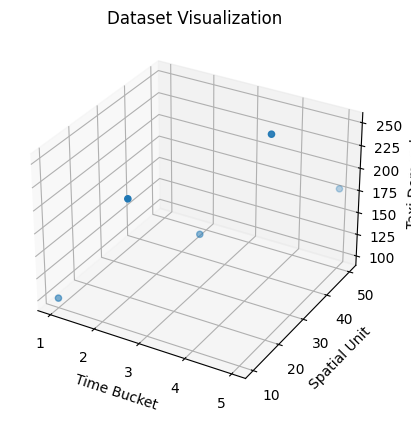

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example dataset
time_bucket = np.array([1, 2, 3, 4, 5])  # Input variable 1: Time bucket
spatial_unit = np.array([10, 20, 30, 40, 50])  # Input variable 2: Spatial unit
taxi_demand = np.array([100, 200, 150, 250, 180])  # Target variable: Taxi demand

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the dataset
ax.scatter(time_bucket, spatial_unit, taxi_demand)

# Set labels and title
ax.set_xlabel('Time Bucket')
ax.set_ylabel('Spatial Unit')
ax.set_zlabel('Taxi Demand')
ax.set_title('Test Dataset Visualization')

# Show the plot
plt.show()


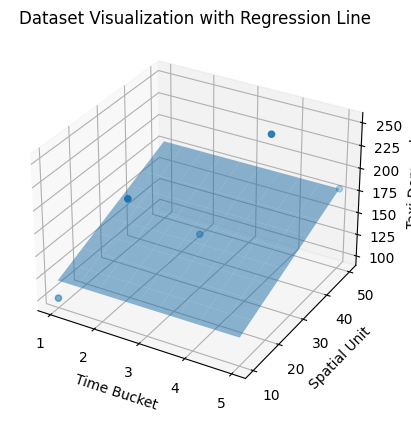

In [3]:
from mpl_toolkits.mplot3d import Axes3D


# Example dataset
time_bucket = np.array([1, 2, 3, 4, 5])  # Input variable 1: Time bucket
spatial_unit = np.array([10, 20, 30, 40, 50])  # Input variable 2: Spatial unit
taxi_demand = np.array([100, 200, 150, 250, 180])  # Target variable: Taxi demand

# Create and train the SVR model
svr = SVR(kernel='linear')
svr.fit(np.column_stack((time_bucket, spatial_unit)), taxi_demand)

# Create a meshgrid of time_bucket and spatial_unit values
time_bucket_mesh, spatial_unit_mesh = np.meshgrid(
    np.linspace(time_bucket.min(), time_bucket.max(), 10),
    np.linspace(spatial_unit.min(), spatial_unit.max(), 10)
)

# Flatten the meshgrid points and make predictions
X_mesh = np.column_stack((time_bucket_mesh.flatten(), spatial_unit_mesh.flatten()))
predictions = svr.predict(X_mesh)

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the dataset
ax.scatter(time_bucket, spatial_unit, taxi_demand)

# Plot the regression surface
ax.plot_surface(time_bucket_mesh, spatial_unit_mesh, predictions.reshape(time_bucket_mesh.shape), alpha=0.5)

# Set labels and title
ax.set_xlabel('Time Bucket')
ax.set_ylabel('Spatial Unit')
ax.set_zlabel('Taxi Demand')
ax.set_title('Test Dataset Visualization with Regression Line')

# Show the plot
plt.show()


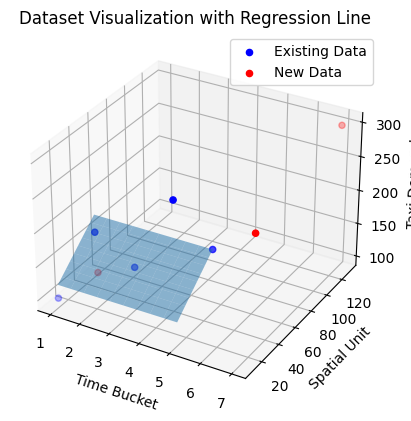

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVR

# Example dataset
time_bucket = np.array([1, 2, 3, 4, 5])  # Input variable 1: Time bucket
spatial_unit = np.array([10, 20, 30, 40, 50])  # Input variable 2: Spatial unit
taxi_demand = np.array([100, 200, 150, 250, 180])  # Target variable: Taxi demand

# Create and train the SVR model
svr = SVR(kernel='linear')
svr.fit(np.column_stack((time_bucket, spatial_unit)), taxi_demand)

# Create a meshgrid of time_bucket and spatial_unit values
time_bucket_mesh, spatial_unit_mesh = np.meshgrid(
    np.linspace(time_bucket.min(), time_bucket.max(), 10),
    np.linspace(spatial_unit.min(), spatial_unit.max(), 10)
)

# Flatten the meshgrid points and make predictions
X_mesh = np.column_stack((time_bucket_mesh.flatten(), spatial_unit_mesh.flatten()))
predictions = svr.predict(X_mesh)

# New data points
new_time_bucket = np.array([6, 2, 7])  # New time bucket values
new_spatial_unit = np.array([64, 22, 130])  # New spatial unit values
new_X = np.column_stack((new_time_bucket, new_spatial_unit))
new_predictions = svr.predict(new_X)

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the dataset
ax.scatter(time_bucket, spatial_unit, taxi_demand, color='blue', label='Existing Data')
ax.scatter(new_time_bucket, new_spatial_unit, new_predictions, color='red', label='New Data')

# Plot the regression surface
ax.plot_surface(time_bucket_mesh, spatial_unit_mesh, predictions.reshape(time_bucket_mesh.shape), alpha=0.5)

# Set labels and title
ax.set_xlabel('Time Bucket')
ax.set_ylabel('Spatial Unit')
ax.set_zlabel('Taxi Demand')
ax.set_title('Dataset Visualization with Regression Line')

# Add a legend
ax.legend()

# Show the plot
plt.show()
